# **Imbalanced Data**

 Imbalanced data (data tak berimbang) adalah kondisi dalam dataset klasifikasi di mana jumlah data dari satu kelas (kelas mayoritas) jauh lebih banyak dibandingkan kelas lain (kelas minoritas). Ketidakseimbangan ini dapat membuat model machine learning menjadi bias, karena lebih cenderung memprediksi kelas mayoritas dan mengabaikan kelas minoritas yang seringkali lebih penting dalam kasus tertentu, seperti deteksi penyakit langka atau penipuan.

## Tugas :

1. Download dataset ecoli dari UCI https://archive.ics.uci.edu/dataset/39/ecoli
2. Simpan didatabase MySQL
3. Tampilkan data dalam scatter plot  menggunakan PCA.
   PCA mentransformasi data menjadi dimensi rendah (2)
4. Lakukan penyeimbangan data menggunakan ADASYN
5. Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya


In [1]:
!pip install pymysql
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.4 MB/s eta 0:00:00


## Ambil data Ecoli yang disimpan di MySQL

In [2]:
import pymysql

mysql_config = {
    "host": "mysql23-112-irismysql23-112.h.aivencloud.com",
    "user": "avnadmin",
    "password": "AVNS_cTNd4CUt1kk0Z7MPIC1",
    "database": "defaultdb",
    "port": 15786
}

def fetch_mysql_data():
    try:
        conn = pymysql.connect(**mysql_config)
        cursor = conn.cursor()
        query = 'SELECT * FROM ecolipsd.ecoli_data;'
        cursor.execute(query)
        data = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        cursor.close()
        conn.close()
        df = pd.DataFrame(data, columns=columns)

        return df
    except pymysql.err.OperationalError as e:
        print(f"Error connecting to MySQL: {e}")
        return pd.DataFrame()

df = fetch_mysql_data()
print(tabulate(df.head(10), headers='keys', tablefmt='grid'))

+----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|    | Sequence   |   mcg |   gvh |   lip |   chg |   aac |   alm1 |   alm2 | class   |
+====+============+=======+=======+=======+=======+=======+========+========+=========+
|  0 | AAS_ECOLI  |  0.44 |  0.52 |  0.48 |   0.5 |  0.43 |   0.47 |   0.54 | im      |
+----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|  1 | AAT_ECOLI  |  0.49 |  0.29 |  0.48 |   0.5 |  0.56 |   0.24 |   0.35 | cp      |
+----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|  2 | ACEA_ECOLI |  0.07 |  0.4  |  0.48 |   0.5 |  0.54 |   0.35 |   0.44 | cp      |
+----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|  3 | ACEK_ECOLI |  0.56 |  0.4  |  0.48 |   0.5 |  0.49 |   0.37 |   0.46 | cp      |
+----+------------+-------+-------+-------+-------+-------+--------+--------+---------+
|  4 | ACKA_ECOLI |  0.59 |  0.4

## Visualisasi data

Data ditampilkan menggunakan PCA yang mana data sudaha ditranspormasikan menjadi 2 dimensi

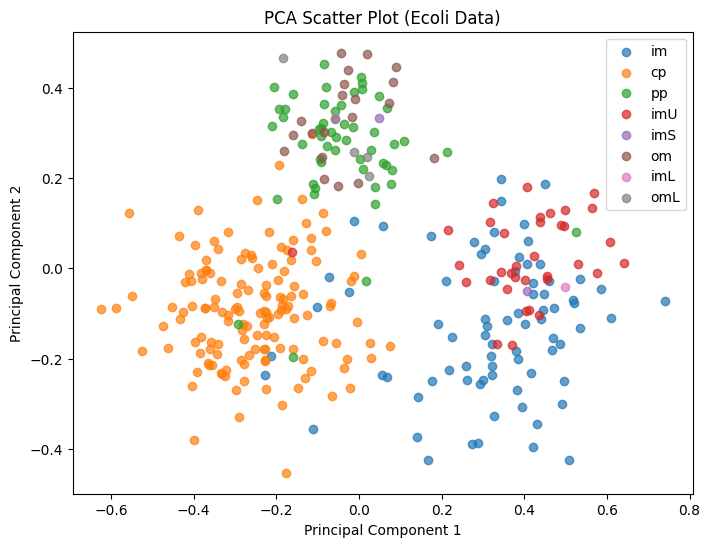

In [3]:
# Pisahkan fitur dan target
X = df.drop(columns=['Sequence','class'])
y = df["class"]

# Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Buat DataFrame hasil PCA
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = df["class"]  # tambahkan class untuk label warna

# Scatter plot
plt.figure(figsize=(8,6))
for c in df_pca["class"].unique():
    subset = df_pca[df_pca["class"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

plt.title("PCA Scatter Plot (Ecoli Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


## **Menampilkan Jumlah Data Pada Setiap Kelas dalam Bentuk Angka dan Grafik**

Jumlah data untuk setiap kelas:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


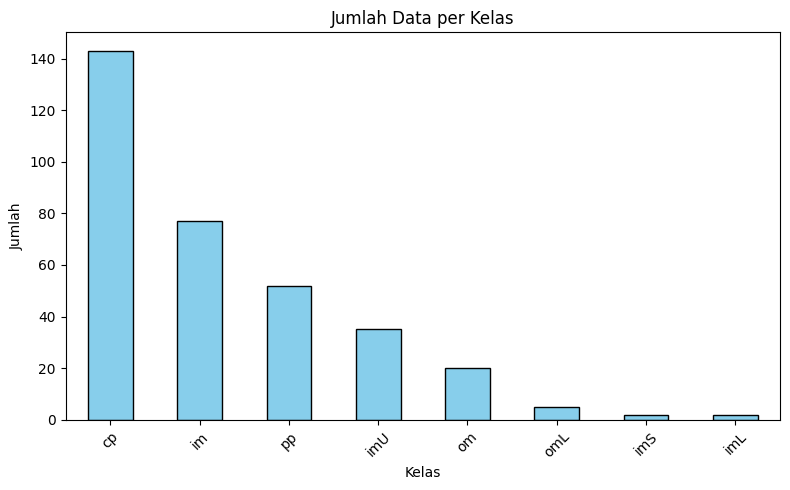

In [4]:
# Ambil data dari MySQL
df = fetch_mysql_data()

# Pastikan kolom kelas ada
if "class" in df.columns:
    # Hitung jumlah data tiap kelas
    class_counts = df["class"].value_counts()

    # Tampilkan dalam bentuk angka
    print("Jumlah data untuk setiap kelas:")
    print(class_counts)

    # Visualisasi dalam bentuk grafik batang
    plt.figure(figsize=(8, 5))
    class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title("Jumlah Data per Kelas")
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'class' tidak ditemukan dalam dataset.")


## **Melakukan Penyeimbangan Menggunakan Smote**

SMOTE (Synthetic Minority Over-sampling Technique) adalah teknik over-sampling yang menghasilkan sampel baru untuk kelas minoritas. Cara kerjanya yaitu:
1. **Memilih sampel minoritas secara acak:** SMOTE memilih sampel dari kelas minoritas secara acak.
2. **Mencari tetangga terdekat:** Untuk sampel yang dipilih, SMOTE menemukan k-tetangga terdekatnya (sampel lain dari kelas minoritas yang sama).
3. **Menghasilkan sampel baru:** Sampel baru dihasilkan di sepanjang garis yang menghubungkan sampel yang dipilih dengan salah satu tetangga terdekatnya. Sampel baru ini merupakan kombinasi fitur dari sampel asli dan tetangganya.



Jumlah data untuk setiap kelas (sebelum SMOTE):
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64

Jumlah data untuk setiap kelas (sesudah SMOTE):
class
im     143
cp     143
pp     143
imU    143
imS    143
om     143
imL    143
omL    143
Name: count, dtype: int64


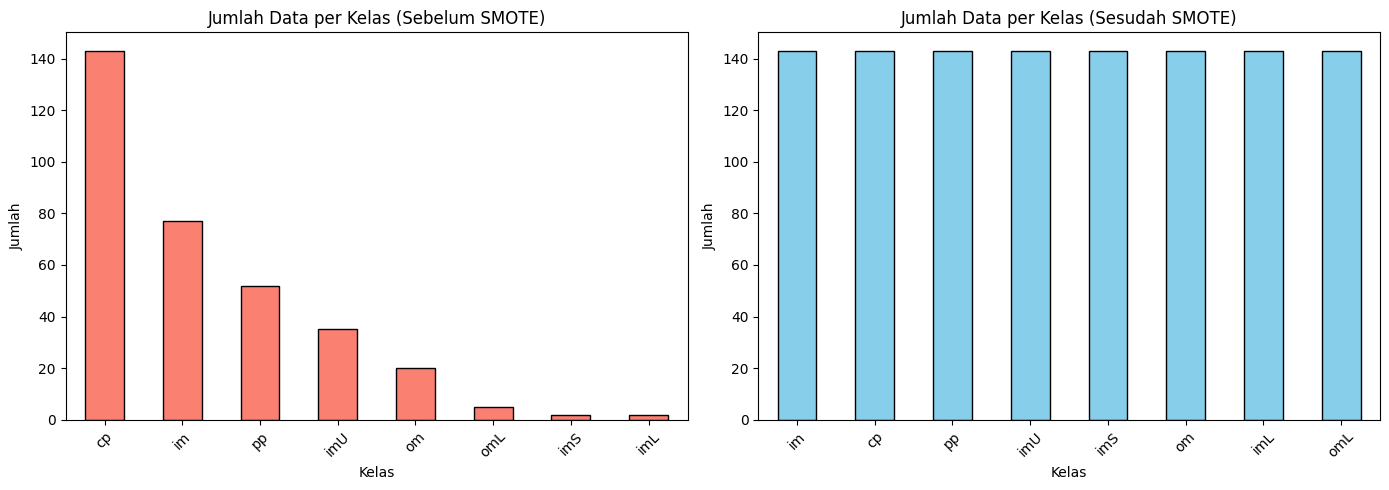

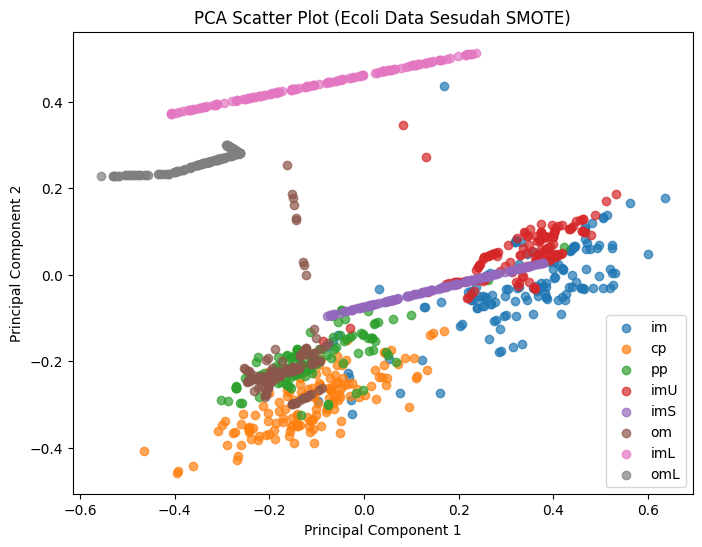

In [5]:
# --- Ambil data dari MySQL ---
df = fetch_mysql_data()

# --- Pastikan kolom 'class' ada ---
if "class" in df.columns:
    # Pisahkan fitur dan target
    X = df.drop(columns=["Sequence", "class"])
    y = df["class"]

    # --- Terapkan SMOTE ---
    # Hitung jumlah data per kelas untuk menentukan k_neighbors secara dinamis untuk SMOTE
    class_counts = y.value_counts()
    # Temukan jumlah minimum sampel di kelas mana pun dengan lebih dari 1 sampel
    min_samples = min(count for count in class_counts.values if count > 1)
    # Atur k_neighbors agar paling banyak min_samples - 1
    k_neighbors = min(5, min_samples - 1) if min_samples > 1 else 1

    smote = SMOTE(random_state=42, k_neighbors=k_neighbors) # Gunakan k_neighbors yang telah dihitung
    X_resampled, y_resampled = smote.fit_resample(X, y)


    # --- Hitung jumlah data sebelum SMOTE ---
    class_counts_before = y.value_counts()
    print("Jumlah data untuk setiap kelas (sebelum SMOTE):")
    print(class_counts_before)

    # --- Hitung jumlah data sesudah SMOTE ---
    class_counts_after = y_resampled.value_counts()
    print("\nJumlah data untuk setiap kelas (sesudah SMOTE):")
    print(class_counts_after)

    # --- Visualisasi perbandingan sebelum dan sesudah ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sebelum SMOTE
    class_counts_before.plot(kind="bar", ax=axes[0], color="salmon", edgecolor="black")
    axes[0].set_title("Jumlah Data per Kelas (Sebelum SMOTE)")
    axes[0].set_xlabel("Kelas")
    axes[0].set_ylabel("Jumlah")
    axes[0].tick_params(axis="x", rotation=45)

    # Sesudah SMOTE
    class_counts_after.plot(kind="bar", ax=axes[1], color="skyblue", edgecolor="black")
    axes[1].set_title("Jumlah Data per Kelas (Sesudah SMOTE)")
    axes[1].set_xlabel("Kelas")
    axes[1].set_ylabel("Jumlah")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # --- (Opsional) PCA untuk visualisasi data hasil SMOTE ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_resampled)

    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["class"] = y_resampled

    plt.figure(figsize=(8, 6))
    for c in df_pca["class"].unique():
        subset = df_pca[df_pca["class"] == c]
        plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

    plt.title("PCA Scatter Plot (Ecoli Data Sesudah SMOTE)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

else:
    print("Kolom 'class' tidak ditemukan dalam dataset.")

Jumlah data untuk setiap kelas (sebelum SMOTE):
Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})

Jumlah data untuk setiap kelas (sesudah SMOTE):
Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


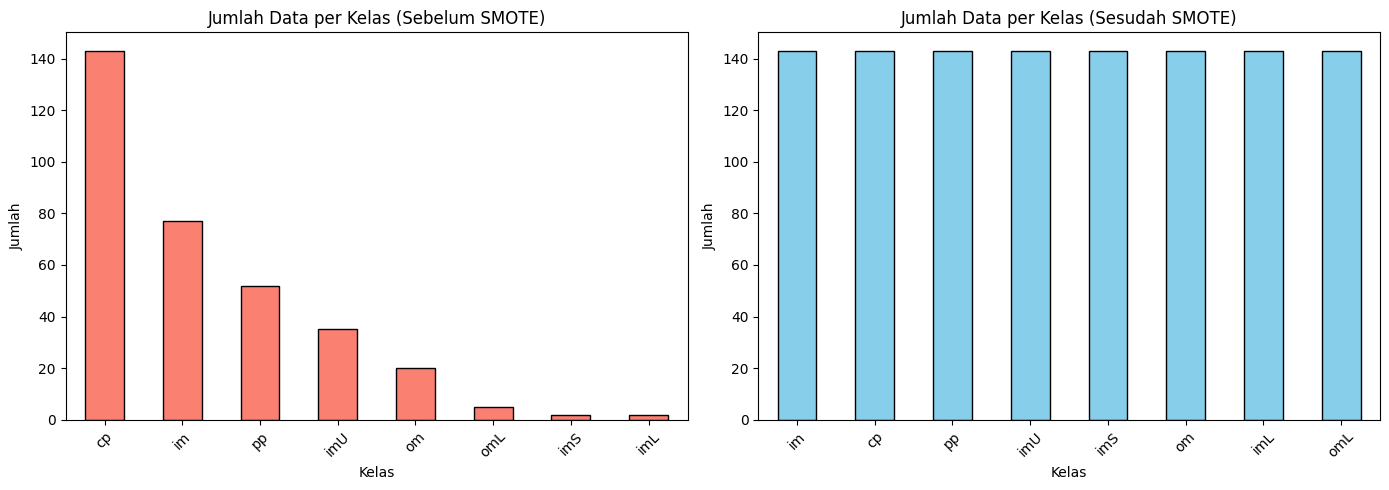

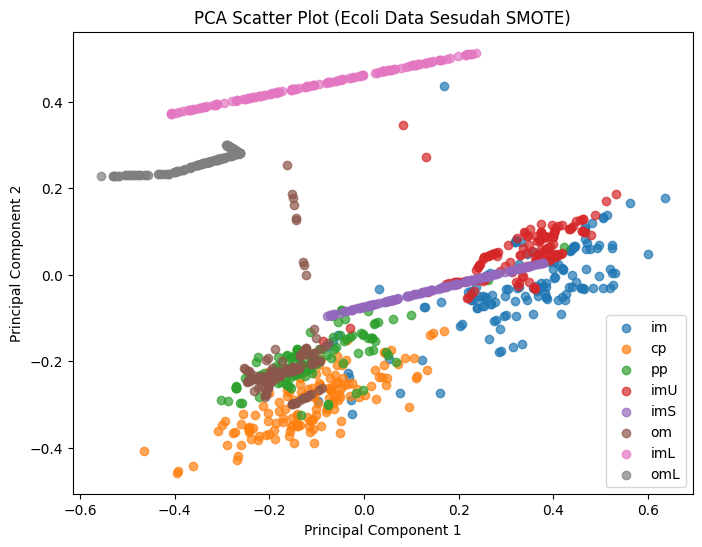

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- Ambil data dari MySQL ---
df = fetch_mysql_data()

# --- Pastikan kolom 'class' ada ---
if "class" in df.columns:
    # Pisahkan fitur dan target
    X = df.drop(columns=["Sequence", "class"])
    y = df["class"]

    # --- Hitung jumlah data sebelum SMOTE ---
    print("Jumlah data untuk setiap kelas (sebelum SMOTE):")
    print(Counter(y))

    # --- Terapkan SMOTE ---
    class_counts = y.value_counts()
    min_samples = min(count for count in class_counts.values if count > 1)
    k_neighbors = min(5, min_samples - 1) if min_samples > 1 else 1

    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # --- Hitung jumlah data sesudah SMOTE ---
    print("\nJumlah data untuk setiap kelas (sesudah SMOTE):")
    print(Counter(y_resampled))

    # --- Visualisasi perbandingan sebelum dan sesudah ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    pd.Series(y).value_counts().plot(kind="bar", ax=axes[0], color="salmon", edgecolor="black")
    axes[0].set_title("Jumlah Data per Kelas (Sebelum SMOTE)")
    axes[0].set_xlabel("Kelas")
    axes[0].set_ylabel("Jumlah")
    axes[0].tick_params(axis="x", rotation=45)

    pd.Series(y_resampled).value_counts().plot(kind="bar", ax=axes[1], color="skyblue", edgecolor="black")
    axes[1].set_title("Jumlah Data per Kelas (Sesudah SMOTE)")
    axes[1].set_xlabel("Kelas")
    axes[1].set_ylabel("Jumlah")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # --- (Opsional) PCA visualisasi data hasil SMOTE ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_resampled)

    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["class"] = y_resampled

    plt.figure(figsize=(8, 6))
    for c in df_pca["class"].unique():
        subset = df_pca[df_pca["class"] == c]
        plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

    plt.title("PCA Scatter Plot (Ecoli Data Sesudah SMOTE)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

else:
    print("Kolom 'class' tidak ditemukan dalam dataset.")


## **Penyeimbangan data menggunakan ADASYN**

Jumlah data untuk setiap kelas (sebelum ADASYN):
Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Kelas im: jumlah=77, menggunakan n_neighbors=5
Kelas pp: jumlah=52, menggunakan n_neighbors=5
Kelas imU: jumlah=35, menggunakan n_neighbors=5
Kelas imS: jumlah=2, menggunakan n_neighbors=1
Kelas om: jumlah=20, menggunakan n_neighbors=5
Kelas imL: jumlah=2, menggunakan n_neighbors=1
Kelas omL: jumlah=5, menggunakan n_neighbors=4

Jumlah data untuk setiap kelas (sesudah ADASYN):
Counter({'im': 156, 'pp': 150, 'cp': 143, 'imU': 143, 'om': 143, 'omL': 143, 'imS': 142, 'imL': 142})


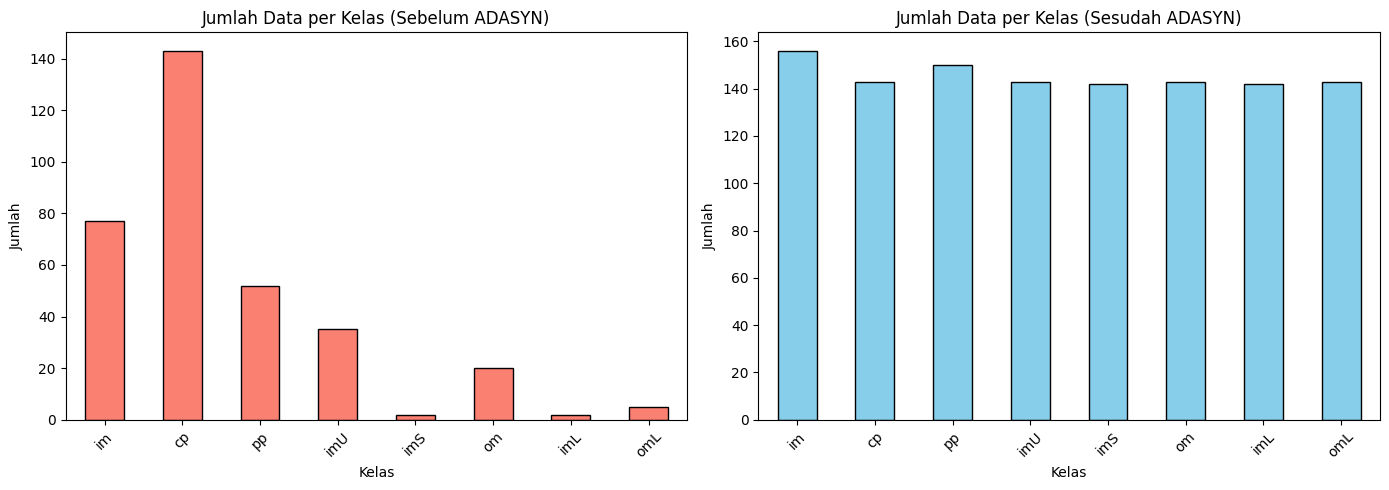

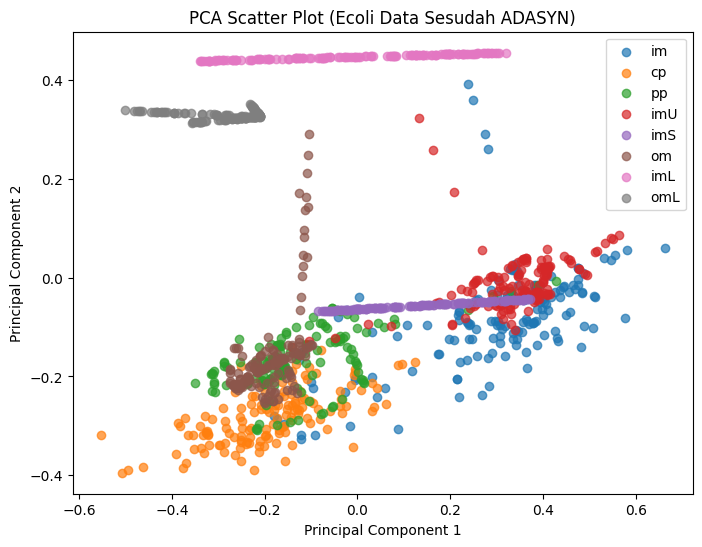

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from collections import Counter

# --- Ambil data dari MySQL ---
df = fetch_mysql_data()

# --- Pastikan kolom 'class' ada ---
if "class" in df.columns:
    # Pisahkan fitur dan target
    X = df.drop(columns=["Sequence", "class"])
    y = df["class"]

    # --- Hitung jumlah data sebelum ADASYN ---
    print("Jumlah data untuk setiap kelas (sebelum ADASYN):")
    print(Counter(y))

    # --- Terapkan ADASYN dengan loop per kelas minor ---
    X_resampled, y_resampled = X.copy(), y.copy()
    class_counts = Counter(y)

    for cls, count in class_counts.items():
        # hanya resample kelas minor
        if count < max(class_counts.values()):
            # tentukan k otomatis
            k = max(1, min(5, count - 1))
            print(f"Kelas {cls}: jumlah={count}, menggunakan n_neighbors={k}")

            adasyn = ADASYN(
                random_state=42,
                sampling_strategy={cls: max(class_counts.values())},
                n_neighbors=k
            )
            X_resampled, y_resampled = adasyn.fit_resample(X_resampled, y_resampled)

    # --- Hitung jumlah data sesudah ADASYN ---
    print("\nJumlah data untuk setiap kelas (sesudah ADASYN):")
    print(Counter(y_resampled))

    # --- Visualisasi perbandingan sebelum dan sesudah ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sebelum ADASYN
    pd.Series(Counter(y)).plot(
        kind="bar", ax=axes[0], color="salmon", edgecolor="black"
    )
    axes[0].set_title("Jumlah Data per Kelas (Sebelum ADASYN)")
    axes[0].set_xlabel("Kelas")
    axes[0].set_ylabel("Jumlah")
    axes[0].tick_params(axis="x", rotation=45)

    # Sesudah ADASYN
    pd.Series(Counter(y_resampled)).plot(
        kind="bar", ax=axes[1], color="skyblue", edgecolor="black"
    )
    axes[1].set_title("Jumlah Data per Kelas (Sesudah ADASYN)")
    axes[1].set_xlabel("Kelas")
    axes[1].set_ylabel("Jumlah")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # --- PCA untuk visualisasi data hasil ADASYN ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_resampled)

    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["class"] = y_resampled

    plt.figure(figsize=(8, 6))
    for c in df_pca["class"].unique():
        subset = df_pca[df_pca["class"] == c]
        plt.scatter(subset["PC1"], subset["PC2"], label=c, alpha=0.7)

    plt.title("PCA Scatter Plot (Ecoli Data Sesudah ADASYN)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

else:
    print("Kolom 'class' tidak ditemukan dalam dataset.")


## Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya

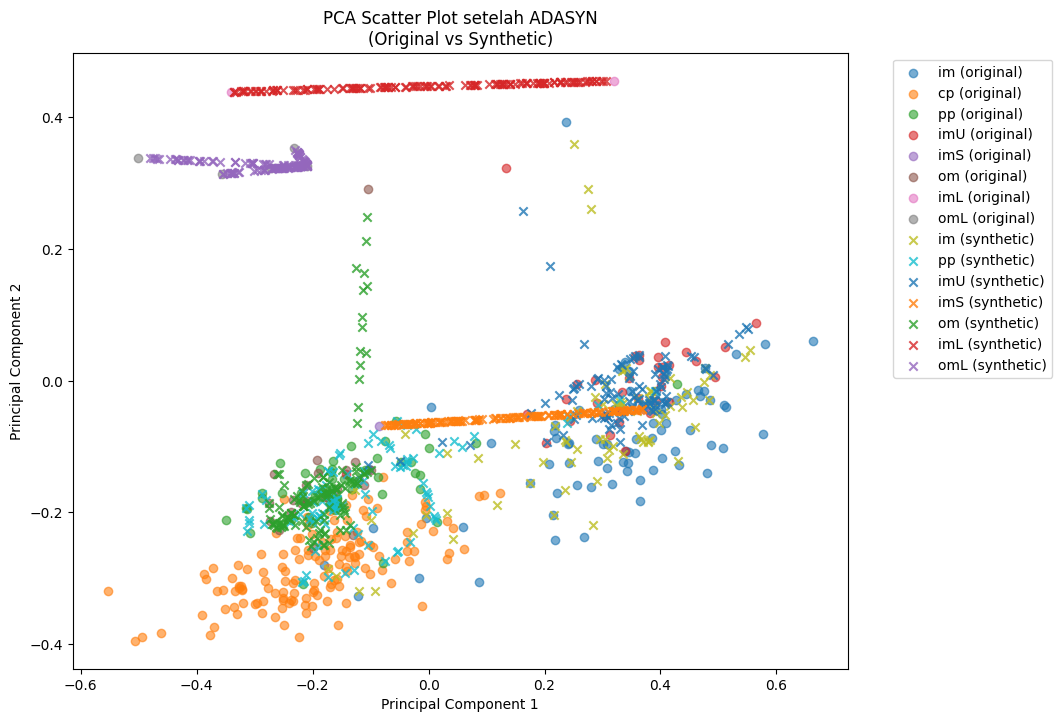

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Simpan jumlah data awal (sebelum ADASYN)
# Mengambil jumlah data dari df asli, bukan dari X
n_original = len(df)

# 2. Lakukan PCA ke 2 dimensi pada data hasil ADASYN
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled) # Menggunakan X_resampled dari ADASYN

# 3. Buat DataFrame hasil PCA untuk plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = y_resampled # Menggunakan y_resampled dari ADASYN

# Tandai data asli vs synthetic
# Asumsikan sampel asli berada di awal X_resampled/y_resampled
df_pca["status"] = ["original"] * n_original + ["synthetic"] * (len(df_pca) - n_original)

# 4. Scatter plot dengan penanda synthetic
plt.figure(figsize=(10,8))

# Plot data original
for c in df_pca["class"].unique():
    subset = df_pca[(df_pca["class"] == c) & (df_pca["status"] == "original")]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"{c} (original)", alpha=0.6, marker='o')

# Plot data synthetic (pakai marker berbeda)
for c in df_pca["class"].unique():
    subset = df_pca[(df_pca["class"] == c) & (df_pca["status"] == "synthetic")]
    if not subset.empty:
        plt.scatter(subset["PC1"], subset["PC2"], label=f"{c} (synthetic)", alpha=0.8, marker='x')

plt.title("PCA Scatter Plot setelah ADASYN\n(Original vs Synthetic)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()